In [1]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [3]:


# Define transforms for data preprocessing
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 training and test datasets using PyTorch's DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)




Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the neural network and use GPU
net = Net()
net.to(device)



Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
# Record the start time
start_time = time.time()

In [6]:
train_loss_list = []

# Training loop
for epoch in range(10):  # Number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels =  data[0].to(device), data[1].to(device)  # Move to GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            train_loss_list.append(running_loss / 100)
            running_loss = 0.0

# Calculate total training time
end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time:.2f} seconds')

# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)  # Move to GPU
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))


[1,   100] loss: 2.102
[1,   200] loss: 1.732
[1,   300] loss: 1.646
[2,   100] loss: 1.560
[2,   200] loss: 1.536
[2,   300] loss: 1.511
[3,   100] loss: 1.469
[3,   200] loss: 1.473
[3,   300] loss: 1.442
[4,   100] loss: 1.421
[4,   200] loss: 1.422
[4,   300] loss: 1.416
[5,   100] loss: 1.386
[5,   200] loss: 1.386
[5,   300] loss: 1.411
[6,   100] loss: 1.359
[6,   200] loss: 1.355
[6,   300] loss: 1.370
[7,   100] loss: 1.328
[7,   200] loss: 1.348
[7,   300] loss: 1.366
[8,   100] loss: 1.311
[8,   200] loss: 1.326
[8,   300] loss: 1.350
[9,   100] loss: 1.296
[9,   200] loss: 1.340
[9,   300] loss: 1.327
[10,   100] loss: 1.264
[10,   200] loss: 1.320
[10,   300] loss: 1.311
Total training time: 115.84 seconds
Accuracy of the network on the 10000 test images: 50.91 %


In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 71 %
Accuracy of  bird : 33 %
Accuracy of   cat : 23 %
Accuracy of  deer : 33 %
Accuracy of   dog : 39 %
Accuracy of  frog : 66 %
Accuracy of horse : 60 %
Accuracy of  ship : 53 %
Accuracy of truck : 56 %


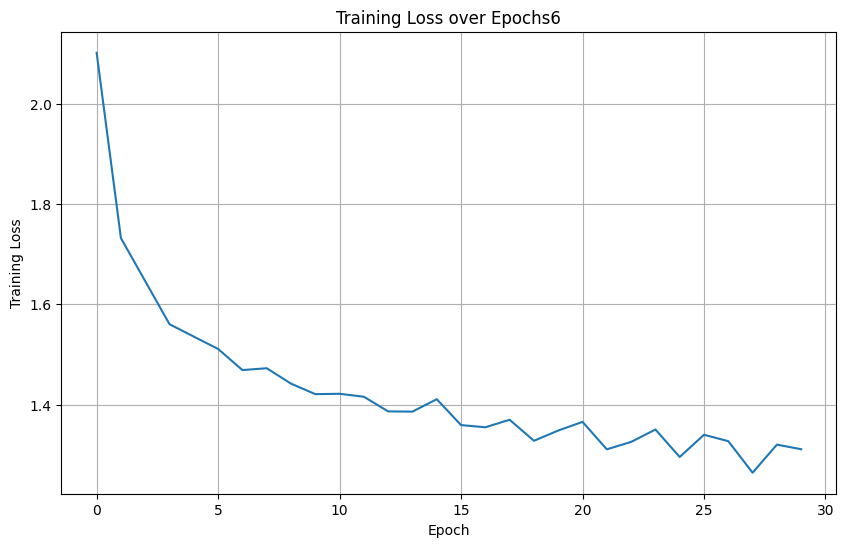

In [8]:
# Configure the plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs6')
plt.grid(True)
plt.show()